In [1]:
# imports for this notebook
%matplotlib inline
import numpy as np
import scipy as sp
import copy
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pystan
from theano import tensor as tt
import pymc3
import scipy.stats as stats

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set_style("whitegrid")
sns.set_context("poster")

import hdp_scripts as hdp
import multivariate_normal
import classification_evaluation as hdp_eval
import data_generation as gen
import imp # for reloading a local script
import time
imp.reload(multivariate_normal)
from multivariate_normal import MultivariateNormal
imp.reload(hdp)
imp.reload(hdp_eval)
imp.reload(gen)

/Users/nickhoernle/anaconda2/envs/ipython3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<module 'data_generation' from '/Users/nickhoernle/Harvard/semester_2/bayesian_MIT/project/notebooks/data_generation.py'>

## Generate some data that might look like ESSIL

In [2]:
df = pd.read_csv('test5-2017-11-16T11-41.csv')
df.head(5)
import datetime

BIOMES = ['Desert_Water', 'Plains_Water', 'Jungle_Water', 'Wetlands_Water']

def clean_column_names(df):
    df.columns = df.columns.str.strip()
    df = df.iloc[1:].reset_index()
    return df

def forward_fill_time(df):
    
    # correct for the seconds that are missing / remove duplicates.
    # forward fill the values in all instances where missing
    
    # convert to datetime object
    time_values = df['Timestamp'].apply(lambda x: datetime.datetime(*[int(v) for v in x.split('-')]))
    # correct the time object in the dataframe
    df['Timestamp'] = time_values
    # create a new dataframe
    df_new = pd.DataFrame({'Timestamp': pd.date_range(time_values.min(), time_values.max(), freq='S')})
    
    return df_new.merge(df, how='left').ffill()

def get_bin_water_values(df, biomes=['Desert', 'Plains', 'Jungle', 'Wetlands']):
    
    # get the bin water value and convert to the same units 
    # as the global water values
    for biome in biomes:
        df[biome+'_BinsWater'] = (df[biome+'_WaterBins'].apply(lambda x: np.sum([float(v) for v in x.split('-')])) + 
                                  df[biome+'_FloodBins'].apply(lambda x: np.sum([float(v) for v in x.split('-')])))/60
    return df

def get_clouds_water(df, biomes=['Desert', 'Plains', 'Jungle', 'Wetlands']):
    
    for biome in biomes:
        df[biome+'_CloudsWater'] = df[biome+'_Water'] - df[biome+'_BinsWater']
        df[biome+'_Water'] = df[biome+'_BinsWater']
        
    df['_CloudWater'] = df[[(b+'_CloudsWater') for b in biomes]].sum(axis=1)
    return df

def filter_to_the_useful_columns(df, 
                                 biomes=["", 'Desert', 'Plains', 'Waterfall', 'Floor', 'Jungle', 'Reservoir', 'Wetlands', 'MountainValley'],
                                 useful=['Water', 'CloudWater']):
    
    known_columns = df.columns
    
    # get the most useful columns out
    columns = []
    for biome in biomes:
        for column in useful:
            suggestion = biome + '_' + column
            if suggestion in known_columns:
                columns.append(suggestion)
    
    return df[columns]

df = clean_column_names(df)
df = forward_fill_time(df)
df = get_bin_water_values(df)
df = get_clouds_water(df)
df = filter_to_the_useful_columns(df)
df.head()

,_CloudWater,Desert_Water,Plains_Water,Waterfall_Water,Floor_Water,Jungle_Water,Reservoir_Water,Wetlands_Water,MountainValley_Water
0,0.0,0.0,0.0,1.87670,0.00971,0.0,0.45,0.0,0.099488
1,0.0,0.0,0.0,1.87536,0.00971,0.0,0.45,0.0,0.093666
2,0.0,0.0,0.0,1.87566,0.00971,0.0,0.45,0.0,0.087303
3,0.0,0.0,0.0,1.87433,0.00971,0.0,0.45,0.0,0.082194
4,0.0,0.0,0.0,1.87531,0.00000,0.0,0.45,0.0,0.077384


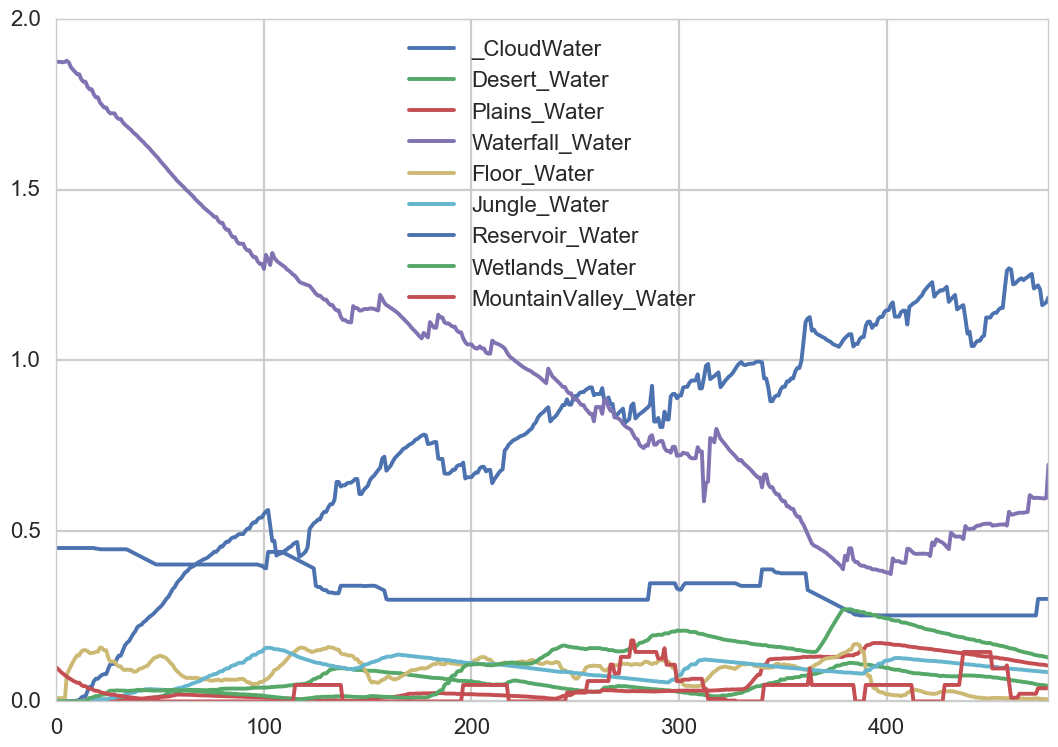

In [3]:
df.plot()

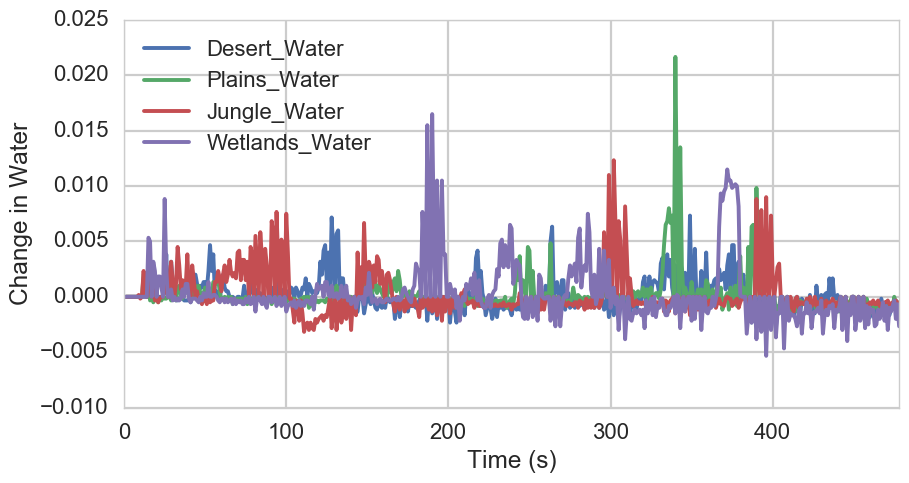

In [4]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
# water = pd.DataFrame(df[BIOMES].values/(1), columns=df[BIOMES].columns, index=df.index).diff()
water = df[BIOMES].diff()
# water[water > .01] = .01
# water[water < -.0025] = -.0025
# for i,w in enumerate(water):
#     plt.plot(water, alpha=.75, label=BIOMES[i])
water.plot(ax=ax)

# plt.legend(loc='best')
plt.ylabel('Change in Water')
plt.xlabel('Time (s)')
plt.show()

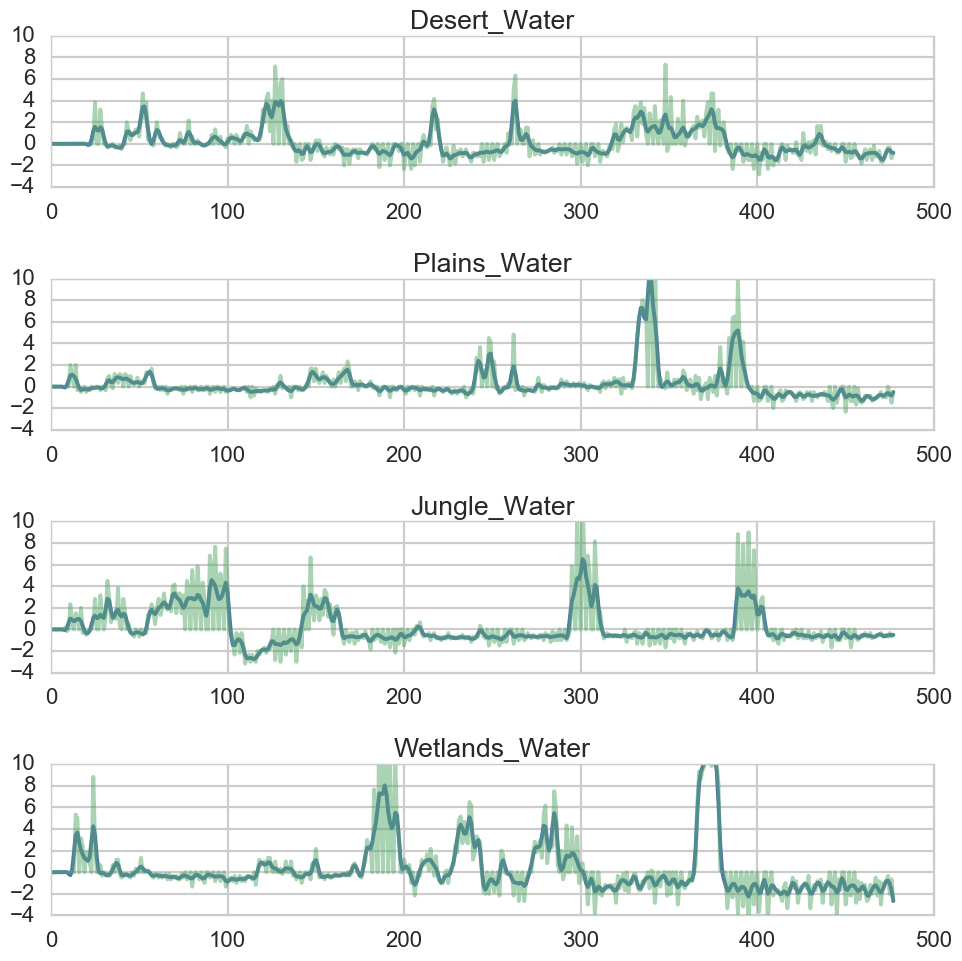

In [7]:
import scipy.signal as signal

# First, design the Buterworth filter
N  = 2  # Filter order
Wn = 0.4# Cutoff frequency
B, A = signal.butter(N, Wn, output='ba')
 
# Second, apply the filter
tempf = [signal.filtfilt(B,A, water[b].values[1:])*1000 for b in BIOMES]
tempf = np.array(tempf).T
Y = tempf

fig, axes = plt.subplots(4,1,figsize=(10,10))

for i,b in enumerate(BIOMES):
    axes[i].plot(tempf[:,i])
    axes[i].plot(water[b].values[1:]*1000, alpha=.5)
    axes[i].set_title(b)
    axes[i].set_ylim([-4,10])
    
fig.tight_layout()
plt.show()

In [54]:
imp.reload(hdp)
imp.reload(hdp_eval)
imp.reload(gen)

def generateTransitionMatrix(dim):
    A = np.random.multivariate_normal(np.zeros(dim), np.eye(dim))
    return A

def generateCovMatrix(dim, M, scale, reg):
    noise_cov = stats.invwishart(scale=scale*np.eye(dim), df=20).rvs()
    return noise_cov

params={}
L = 10
D = 4

params['pi'] = np.random.dirichlet(alpha=np.ones(L), size=L)
params['D'] = D
params['theta'] = [{'A': generateTransitionMatrix(D), 'sigma': generateCovMatrix(D, np.zeros(shape=(D, D)),2 ,5)} for i in range(L)]
params['L'] = L
params['Y'] = Y
params['T'] = len(Y)
params['alpha'] = .1
params['beta'] = np.random.dirichlet(np.ones(params['L']))
params['kappa'] = 0.1*len(Y)
params['gamma'] = .1
params['priors'] = {
    'M': np.zeros(shape=(D)),
    'K': 10 # force a tight regularization
}

params, res, assignments, _ = hdp.sticky_HMM_multi(Y, params, priors=[params['priors']['M'], params['priors']['K'], np.eye(D), D+2],
                                                         num_iter=100,
                                                         return_assignments=True,
                                                         verbose=True,
                                                         chains=np.zeros_like(Y[:,0]))

Iteration: 0, # inf chain: 10, time: 1.35, hamming_dist: 409.000


/Users/nickhoernle/anaconda2/envs/ipython3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Iteration: 10, # inf chain: 8, time: 1.38, hamming_dist: 39.000
Iteration: 20, # inf chain: 9, time: 1.33, hamming_dist: 37.000
Iteration: 30, # inf chain: 10, time: 1.36, hamming_dist: 31.000
Iteration: 40, # inf chain: 10, time: 1.38, hamming_dist: 35.000
Iteration: 50, # inf chain: 10, time: 1.40, hamming_dist: 38.000
Iteration: 60, # inf chain: 10, time: 1.36, hamming_dist: 28.000
Iteration: 70, # inf chain: 10, time: 1.34, hamming_dist: 33.000
Iteration: 80, # inf chain: 10, time: 1.35, hamming_dist: 32.000
Iteration: 90, # inf chain: 10, time: 1.40, hamming_dist: 22.000


In [55]:
res = np.median(assignments[:,int(assignments.shape[1]*.75):], axis=1).astype(np.int8)

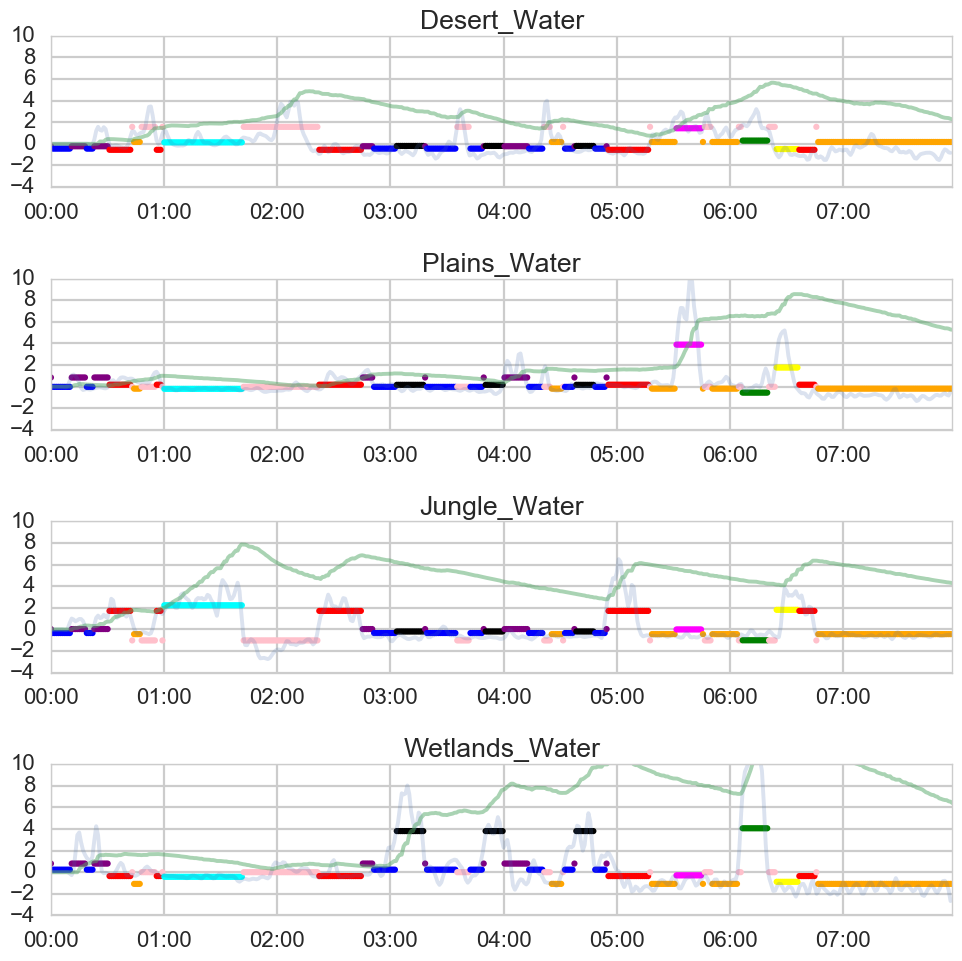

In [56]:
c=['blue', 'yellow', 'green', 'orange', 'magenta', 'purple', 'pink', 'black', 'cyan', 'red', 'indigo', 'violet']

fig, axes = plt.subplots(4,1,figsize=(10,10))
formatter = mpl.ticker.FuncFormatter(lambda ms, x: time.strftime('%M:%S', time.gmtime(ms)))

for i, biome in enumerate(BIOMES):
    mean = [params['theta'][val]['A'][i] for val in res]

    axes[i].plot(Y[:,i], alpha=.2)
    axes[i].scatter(np.linspace(0, len(res), num=len(res)), mean, c=[c[i] for i in res], lw=0)
    axes[i].set_title(biome)
    axes[i].set_ylim([-4,10])
    axes[i].set_xlim([0,520])
    axes[i].set_xticks(np.arange(start=0, stop=520, step=60))
    axes[i].set_xticklabels(np.arange(start=0, stop=520, step=60))
    axes[i].xaxis.set_major_formatter(formatter)
    (df[biome]*50).plot(ax=axes[i], alpha=.5)

fig.tight_layout()
plt.show()

In [57]:
def get_interesting_params(theta, threshold_upper=.5, threshold_lower=-.5):
    
    interesting_information = {}
    for i, biome in enumerate(BIOMES):
        
        if theta[i] > threshold_upper:
            interesting_information[biome] = ('Water increasing', theta[i])
        if theta[i] < threshold_lower:
            interesting_information[biome] = ('Water decreasing', theta[i])
    return interesting_information

In [58]:
def interesting_conditions(interesting_info, start_time, end_time):
    if len(interesting_info) <= 0:
        return False
    if end_time - start_seconds <= 15:
        return False
    return True

In [59]:
def format_seconds_to_minutes(seconds):
    num_min = seconds//60
    num_sec = seconds - (num_min * 60)
    return "%02d:%02d"%(num_min,num_sec)

In [60]:
print('PRINTING POSSIBLE POINTS OF INTEREST')
print('------------------------------------')
print()

t = 1
start_seconds = 0
state_tmin1 = res[0]

while t < len(Y):
    
    state = res[t]
    
    if state != state_tmin1:
        end_seconds = t
        
        interesting_info = get_interesting_params(params['theta'][res[t-1]]['A'])
        if interesting_conditions(interesting_info, start_seconds, end_seconds):
            print('Interesting Event')
            print('Start time:\t{}\t{}'.format(format_seconds_to_minutes(start_seconds), format_seconds_to_minutes(8*60-start_seconds)))
            print('End time:\t{}\t{}'.format(format_seconds_to_minutes(end_seconds), format_seconds_to_minutes(8*60-end_seconds)))
            for k,v in interesting_info.items():
                print('event:\t\t{event} in {biome} with param {param}'.format(event=v[0], biome=k, param=round(v[1],2)))
            print()
        
        start_seconds = t
    
    state_tmin1 = state
    t += 1

PRINTING POSSIBLE POINTS OF INTEREST
------------------------------------

Interesting Event
Start time:	01:00	07:00
End time:	01:42	06:18
event:		Water increasing in Jungle_Water with param 2.24

Interesting Event
Start time:	01:42	06:18
End time:	02:22	05:38
event:		Water increasing in Desert_Water with param 1.57
event:		Water decreasing in Jungle_Water with param -1.02

Interesting Event
Start time:	02:22	05:38
End time:	02:45	05:15
event:		Water decreasing in Desert_Water with param -0.55
event:		Water increasing in Jungle_Water with param 1.71

Interesting Event
Start time:	04:55	03:05
End time:	05:17	02:43
event:		Water decreasing in Desert_Water with param -0.55
event:		Water increasing in Jungle_Water with param 1.71



# Treat the individual streams separately

In [25]:
from multiprocessing import Pool

params = {}

L, D = 10, 1
Y = tempf
chains = np.ones(Y.shape[0])

params['pi'] = np.random.dirichlet(alpha=np.ones(L), size=L)
params['D'] = D
params['theta'] = [{'A': np.random.normal(0,1), 'sigma': np.random.gamma(1,1)} for i in range(L)]
params['L'] = L
params['Y'] = Y
params['T'] = len(Y)
params['alpha'] = 10
params['beta'] = np.random.dirichlet(10*np.ones(params['L']))
params['kappa'] = .5*len(Y)
params['gamma'] = 1e-2
params['priors'] = {
    'M': 0,
    'K': 1e-1
}

def run_inference(y, starting_params, id_, **kwargs):
    
    params = copy.deepcopy(starting_params)
    params, res, assignments, _ = hdp.sticky_HMM(y, params, priors=[0, 1, 1, 10],
                                             num_iter=100,
                                             return_assignments=True,
                                             verbose=True,
                                             chains=chains)
    return {
        'params': params,
        'assignments': assignments,
        'id': id_
    }

In [26]:
numprocs = 4
pool = Pool(numprocs)
kwargs = {'test': 0}

results = []
for i,y in enumerate(Y.T):
    results.append(pool.apply_async(run_inference, args=(y, params, i, ), kwds=kwargs))

result_params = {}
result_assignments = {}

for result in results:
    res_ = result.get()
    result_params[res_['id']] = res_['params']
    result_assignments[res_['id']] = res_['assignments']

Iteration: 0, # inf chain: 10, time: 1.26, hamming_dist: 352.000
Iteration: 0, # inf chain: 10, time: 1.26, hamming_dist: 375.000
Iteration: 0, # inf chain: 10, time: 1.28, hamming_dist: 361.000
Iteration: 0, # inf chain: 10, time: 1.31, hamming_dist: 354.000
Iteration: 10, # inf chain: 9, time: 1.32, hamming_dist: 20.000
Iteration: 10, # inf chain: 8, time: 1.36, hamming_dist: 62.000
Iteration: 10, # inf chain: 8, time: 1.33, hamming_dist: 45.000
Iteration: 10, # inf chain: 7, time: 1.34, hamming_dist: 32.000
Iteration: 20, # inf chain: 9, time: 1.46, hamming_dist: 33.000
Iteration: 20, # inf chain: 8, time: 1.48, hamming_dist: 44.000
Iteration: 20, # inf chain: 6, time: 1.47, hamming_dist: 39.000
Iteration: 20, # inf chain: 8, time: 1.48, hamming_dist: 61.000
Iteration: 30, # inf chain: 9, time: 1.31, hamming_dist: 46.000
Iteration: 30, # inf chain: 8, time: 1.27, hamming_dist: 45.000
Iteration: 30, # inf chain: 8, time: 1.27, hamming_dist: 65.000
Iteration: 30, # inf chain: 6, time:

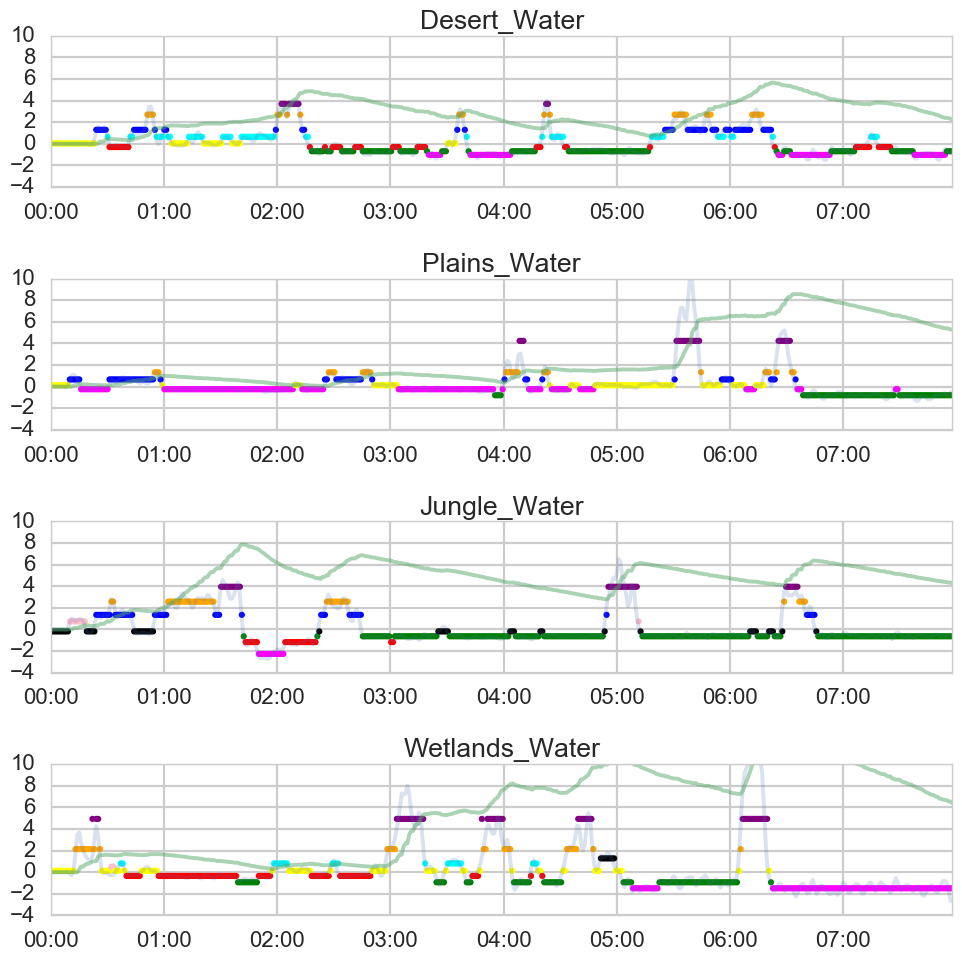

In [28]:
c=['blue', 'yellow', 'green', 'orange', 'magenta', 'purple', 'pink', 'black', 'cyan', 'red', 'indigo', 'violet']

fig, axes = plt.subplots(4,1,figsize=(10,10))
formatter = mpl.ticker.FuncFormatter(lambda ms, x: time.strftime('%M:%S', time.gmtime(ms)))

for i, biome in enumerate(BIOMES):
    
    assignments = result_assignments[i]
    res = np.median(assignments[:,int(assignments.shape[1]*.75):], axis=1).astype(np.int8)
    
    params = result_params[i]
    mean = [params['theta'][val]['A'] for val in res]

    axes[i].plot(Y[:,i], alpha=.2)
    axes[i].scatter(np.linspace(0, len(res), num=len(res)), mean, c=[c[i] for i in res], lw=0)
    axes[i].set_title(biome)
    axes[i].set_ylim([-4,10])
    axes[i].set_xlim([0,520])
    axes[i].set_xticks(np.arange(start=0, stop=520, step=60))
    axes[i].set_xticklabels(np.arange(start=0, stop=520, step=60))
    axes[i].xaxis.set_major_formatter(formatter)
    (df[biome]*50).plot(ax=axes[i], alpha=.5)

fig.tight_layout()
plt.show()